In [1]:
#Read GPS data. I have deleted the first column.

import pandas as pd


data = pd.read_csv('GPS_data.csv')
data.head()

,seconds_elapsed,longitude,latitude
0,3.703666,25.516165,65.071375
1,5.339879,25.516227,65.071393
2,5.680000,25.516240,65.071398
3,6.311351,25.516264,65.071394
4,7.323929,25.516267,65.071396


In [2]:
#Plot the map

import folium
import numpy as np

location_frame = data[['latitude', 'longitude']]
location_list = location_frame.values.tolist()

ave_lat = np.mean(location_list, axis = 0)[0]
ave_lon = np.mean(location_list, axis = 0)[1]

my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=14)

folium.PolyLine(location_list, color="red", weight=2.5, opacity=1).add_to(my_map)

my_map

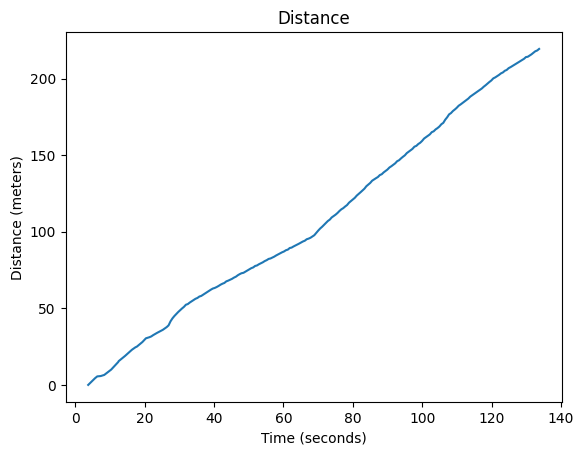

In [3]:
#Plot distance graph

from geopy.distance import geodesic
import matplotlib.pyplot as plt

df = pd.read_csv('GPS_data.csv')

df['distance'] = 0.0
for i in range(1, len(df)):
    coords_1 = (df['latitude'][i-1], df['longitude'][i-1])
    coords_2 = (df['latitude'][i], df['longitude'][i])
    distance = geodesic(coords_1, coords_2).meters
    df.at[i, 'distance'] = distance

df['cumulative_distance'] = df['distance'].cumsum()

plt.plot(df['seconds_elapsed'], df['cumulative_distance'])
plt.title('Distance')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance (meters)')
plt.show()

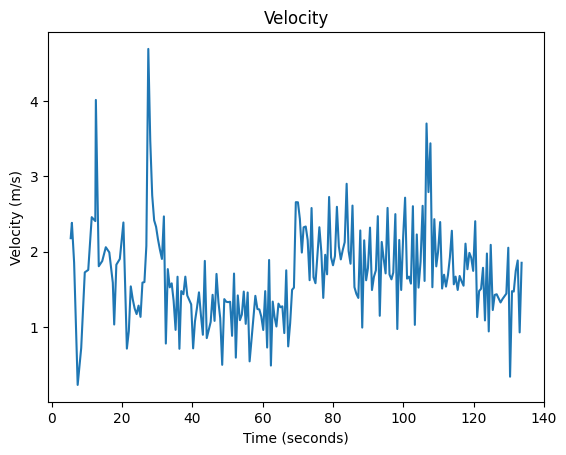

In [4]:
#Plot velocity graph

from math import radians, sin, cos, sqrt, asin

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
   
    dlon = lon2 - lon1
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r 

data = pd.read_csv('GPS_data.csv')

data['dist'] = [haversine(lon1, lat1, lon2, lat2) * 1000 for lon1, lat1, lon2, lat2 in zip(data['longitude'].shift(), data['latitude'].shift(), data['longitude'], data['latitude'])]
data['time_diff'] = data['seconds_elapsed'].diff()

data.loc[0, ['dist', 'time_diff']] = 0

data['velocity'] = data['dist'] / data['time_diff']

import matplotlib.pyplot as plt

plt.plot(data['seconds_elapsed'], data['velocity'])
plt.title('Velocity')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.show()


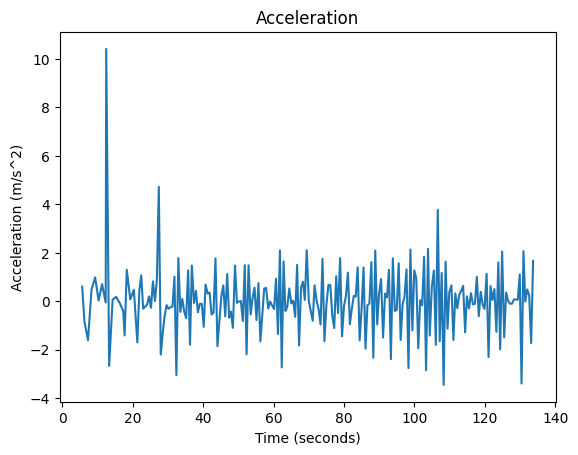

In [5]:
#Plot acceleration graph

data['acceleration'] = data['velocity'].diff() / data['time_diff']

plt.plot(data['seconds_elapsed'], data['acceleration'])
plt.title('Acceleration')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (m/s^2)')
plt.show()


In [6]:
#Calculate average speed

total_time_seconds = df['seconds_elapsed'].iloc[-1] - df['seconds_elapsed'].iloc[0]
total_distance = df['cumulative_distance'].iloc[-1]
average_speed = total_distance / total_time_seconds

print(f"Average speed is {average_speed:.3f} m/s")

Average speed is 1.687 m/s


In [7]:
#Traveled distance

total_distance = df['cumulative_distance'].iloc[-1]
print(f"Total distance is {total_distance:.3f} m")

Total distance is 219.343 m


In [8]:
#Read acceleration data. I have deleted the first column.

data = pd.read_csv('Acceleration_data.csv')
data.head()

,seconds_elapsed,z,y,x
0,0.143440,-2.846008,-0.581977,-0.468246
1,0.159217,-2.651466,-0.560432,-0.418557
2,0.175117,-2.132024,-0.366186,-0.535990
3,0.190986,-1.023350,-0.041039,-0.522485
4,0.206763,-0.449766,0.229015,-0.356920


In [9]:
#Calculate steps

data = pd.read_csv('Acceleration_data.csv')

from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b,a = butter(order, normal_cutoff, btype='low', analog=False)
    return b,a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b,a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b,a, data)
    return y

order = 6
fs = 30
cutoff = 1.5
stepdata = butter_lowpass_filter(data['z'], cutoff, fs, order)

stepdata = np.array(stepdata)

steps = 0
for i in range(len(stepdata) - 1):
    if stepdata[i] * stepdata[i + 1] < 0:
        steps +=0.5
steps = int(steps)
print("The number of steps is",steps)


The number of steps is 256


Acceleration is calculated as the velocity difference divided by the time difference. The accuracy of this calculation depends on the quality and accuracy of the velocity data.

The step count detection logic increases by 0.5 for every zero crossing and the step count seems to be too low.

Integrate all content learned in the course.